# Clustering US Partisanship
## Juan Pablo Brasdefer
#### December 2024
#### DSIII: Advanced Modeling Techniques
#### Prof. Brodnax

This notebook makes up the modeling implementation portion of the study. This notebook assumes that the data cleaning laid out in the file "code/data_cleaning.Rmd" has been executed.

This notebook delves into the final pre-processing steps and the implementation of the chosen clustering methods. 
First the pipeline is carried out for the full dataset, and second, it is carried out for the 'subset' dataset (only counties with above-average margin changes).

Key techniques applied:
Yeo-Johnson Transformation (Standardization substitute), KMeans Clustering, DBScan Clustering.

# Libraries

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# task-specific libraries
from sklearn.preprocessing import PowerTransformer # alternative to StandardScaler: Yeo-Johnson Transformation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# PART ONE - FULL DATASET

# Explore Data and Distributions of Features

In [3]:
# loading joined data
votecensus_2020 = pd.read_csv('../data/clean/votemargins_census_joined_2020.csv') # relative path
votecensus_2020_clustered = votecensus_2020.copy() # quick copy to retain raw data in case needed

# quick view of df
votecensus_2020_clustered.head()

,unique_id,year,state_po,county_name,votemargin_DR,proportion_explained_by_DR,totalvotes,Education,Immigration,Income,Unemployment,Marital
0,2020_01001,2020,AL,AUTAUGA,-44.4,98.5,27770,28.3,2.3,28.6,1.7,28.9
1,2020_01003,2020,AL,BALDWIN,-53.8,98.6,109679,31.9,3.4,31.6,2.3,27.1
2,2020_01005,2020,AL,BARBOUR,-7.7,99.2,10518,11.6,2.6,10.2,3.2,41.8
3,2020_01007,2020,AL,BIBB,-57.7,99.1,9595,11.3,1.6,23.6,3.6,39.8
4,2020_01009,2020,AL,BLOUNT,-80.0,99.1,27588,13.3,4.4,21.3,2.7,27.1


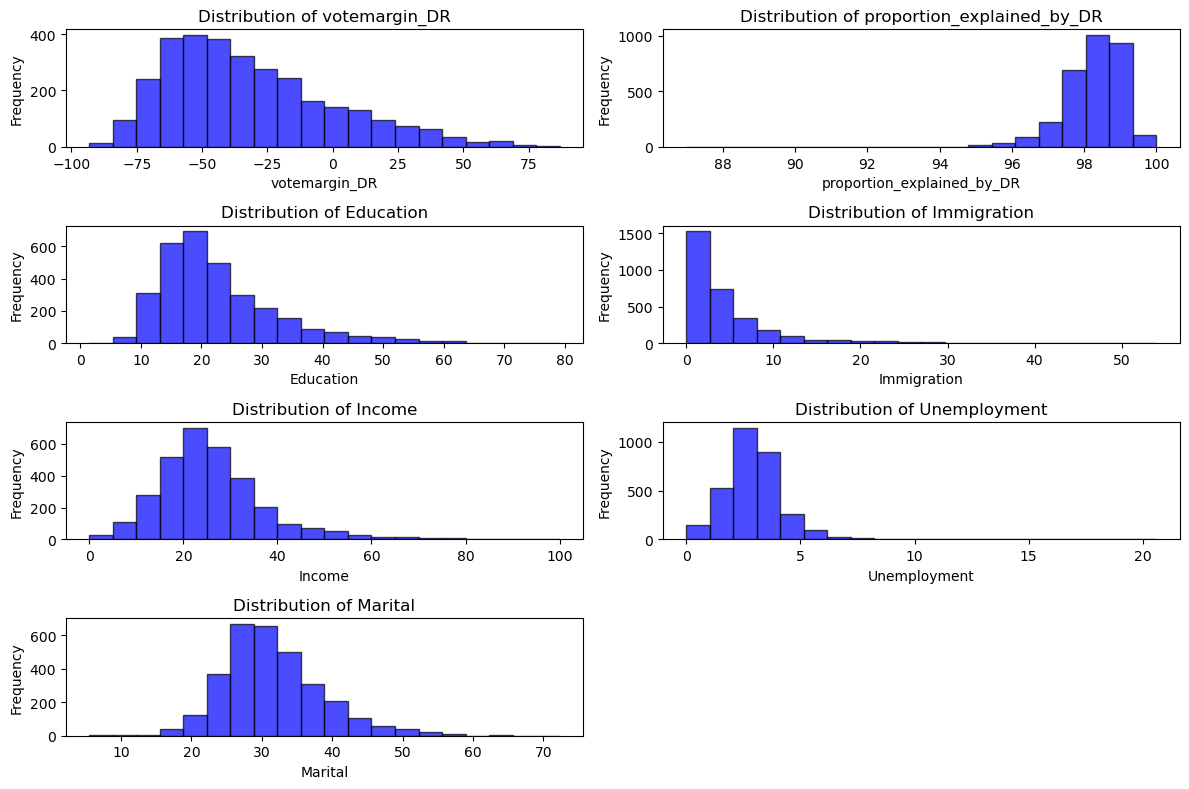

In [7]:
# explore distribution of variables

# state our columns of interest
columns = ['votemargin_DR', 
           'proportion_explained_by_DR', 
           'Education', 
           'Immigration', 
           'Income',
          'Unemployment',
          'Marital']

# set up the matplotlib histogram
plt.figure(figsize=(12, 8))

#looping over our variable (columns) to create histograms
for i, column in enumerate(columns, 1):
    plt.subplot(4, 2, i)  # create a 4x2 grid for 7 plots
    plt.hist(votecensus_2020[column], 
             bins=20, 
             color='blue', 
             edgecolor='black', 
             alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# layout and print
plt.tight_layout()
plt.show()

Given that our features are not on the same scale, we are going to standardize!
But, given the skew we see in FOREIGN BORN and  PROPORTION EXPLAINED BY DR, we will have to use a transformation that is better than vanilla Standardization at handling outliers and skewness.

In [9]:
# define features (ie: get rid of columns like ID columns that don't contribute quantitatively to our efforts.
features = votecensus_2020.drop(columns=['unique_id', 'year', 'state_po', 'county_name', 'totalvotes'])  # drop non-feature columns
features.columns

Index(['votemargin_DR', 'proportion_explained_by_DR', 'Education',
       'Immigration', 'Income', 'Unemployment', 'Marital'],
      dtype='object')

# FULL DATASET - YEO-Johnson Transformation (Alternative to Standardization)

In [13]:
# Yeo-Johnson Transformation (handles zero and negative values):
pt = PowerTransformer(method='yeo-johnson') # create instance of transformer/scaler 

features_yeo = pt.fit_transform(features) # transform the data

features_yeo_df = pd.DataFrame(features_yeo, columns=features.columns) # create new dataframe from transformed features

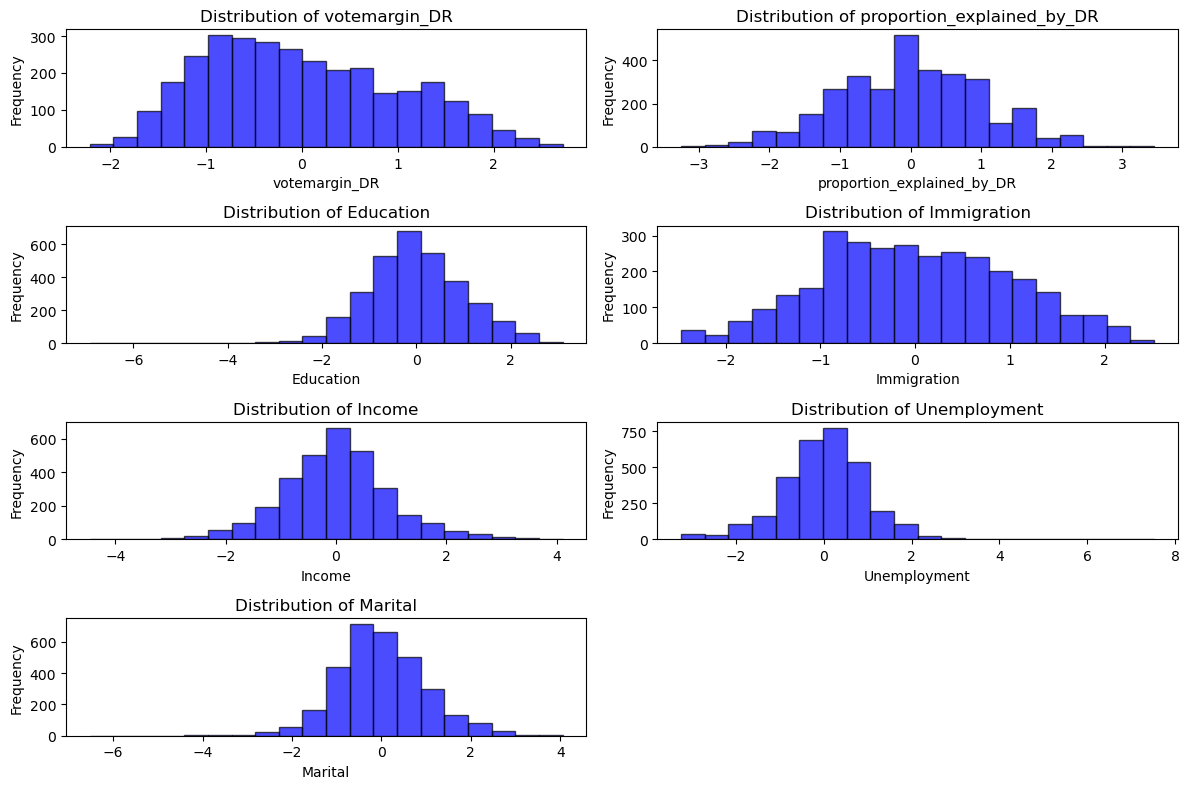

In [15]:
# plot histograms post-transformation to see effect

# set up the matplotlib histogram
plt.figure(figsize=(12, 8))

# looping over our variable (columns) to create histograms
# remembering that the object 'columns' is defined already
for i, column in enumerate(columns, 1):
    plt.subplot(4, 2, i)  # create a 4x2 grid for 7 plots
    plt.hist(features_yeo_df[column], 
             bins=20, 
             color='blue', 
             edgecolor='black', 
             alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# layout and print
plt.tight_layout()
plt.show()

Looks like out transformation had the intended effect! We can move now to the actual methods of interest.

# FULL DATASET - KMEANS

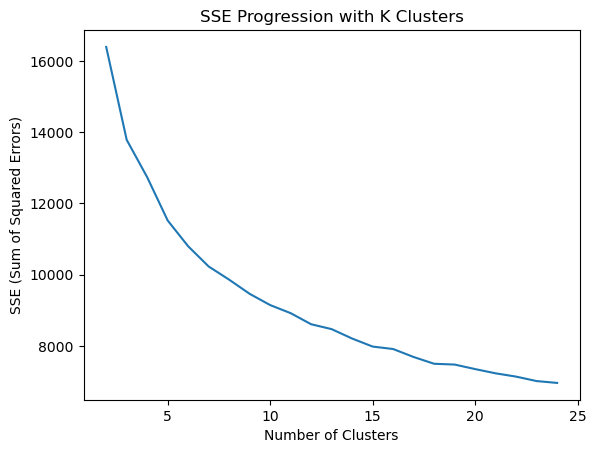

In [17]:
# first, let's find a good value for k

# inertia is our added SSEs, so lets find it for each k
# forloop over range 2-25
inertia = [KMeans(n_clusters=i).fit(features_yeo_df).inertia_ for i in range(2,25)]

# take the inertia and put it on an elbow plot
plt.plot(range(2,25), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('SSE Progression with K Clusters')
plt.show()

In [19]:
# let's incorporate Silhouette Scores for the same purpose


# iterate through different values of k
for k in range(2, 25):
    # fit the KMeans model
    model = KMeans(n_clusters=k, random_state=42) # random state for replicability
    labels = model.fit_predict(features_yeo_df)
    
    # compute silhouette score
    score = silhouette_score(features_yeo_df, labels)
    
    # count the number of observations in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # print results
    print(f"K = {k}")
    print(f"Silhouette Score: {score:.4f}")
    print("Cluster Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Cluster {label}: {count} observations")
    print("-" * 50)


K = 2
Silhouette Score: 0.2365
Cluster Distribution:
  Cluster 0: 1075 observations
  Cluster 1: 2038 observations
--------------------------------------------------
K = 3
Silhouette Score: 0.1998
Cluster Distribution:
  Cluster 0: 895 observations
  Cluster 1: 1367 observations
  Cluster 2: 851 observations
--------------------------------------------------
K = 4
Silhouette Score: 0.1663
Cluster Distribution:
  Cluster 0: 548 observations
  Cluster 1: 1137 observations
  Cluster 2: 650 observations
  Cluster 3: 778 observations
--------------------------------------------------
K = 5
Silhouette Score: 0.1597
Cluster Distribution:
  Cluster 0: 886 observations
  Cluster 1: 608 observations
  Cluster 2: 317 observations
  Cluster 3: 785 observations
  Cluster 4: 517 observations
--------------------------------------------------
K = 6
Silhouette Score: 0.1599
Cluster Distribution:
  Cluster 0: 756 observations
  Cluster 1: 505 observations
  Cluster 2: 304 observations
  Cluster 3: 623 

In [21]:
# seems like 10 is a good place to stop, even though silhouette drops pretty badly from k = 3 to k = 4
# and k = 10 has a sad silhouette score of 0.1383
k = 10
model = KMeans(n_clusters=k, random_state=42) # use our value of k
kmeans_labels = model.fit_predict(features_yeo_df) # fit predicct

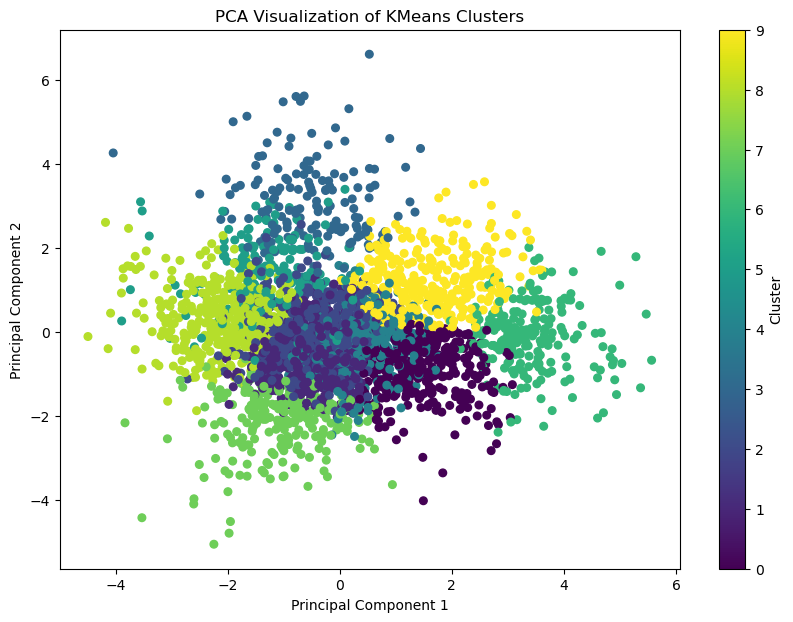

In [23]:
# let's do a quick visualization of what our clusters look like in a lower-dimensional space

# apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2) # n components = 2
features_pca = pca.fit_transform(features_yeo_df) # fit transform

# cisualize the clusters in 2D
plt.figure(figsize=(10, 7))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of KMeans Clusters')
plt.show()

Seems like some clusters are significantly better-separated than others. We can see why our silhouette scores suffered so much...
Now let's move to DBScan to see where we can find some overlap!

# FULL DATASET - DBSCAN

In [25]:
# first, let's find a desirable Epsilon value (to determine radius of point-to-point) cluster expansion

for eps_val in [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:  # test multiple values
    dbscan = DBSCAN(eps=eps_val, min_samples=5) # min samples of 5! we don't want tiny clusters!
    dbscan_labels = dbscan.fit_predict(features_yeo_df)
    print(f"eps={eps_val}, Number of Clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}, Noise Points: {np.sum(dbscan_labels == -1)}")

eps=0.5, Number of Clusters: 2, Noise Points: 3100
eps=0.6, Number of Clusters: 23, Noise Points: 2840
eps=0.7, Number of Clusters: 21, Noise Points: 2268
eps=0.8, Number of Clusters: 13, Noise Points: 1591
eps=0.9, Number of Clusters: 5, Noise Points: 1090
eps=1, Number of Clusters: 3, Noise Points: 721
eps=1.1, Number of Clusters: 4, Noise Points: 486
eps=1.2, Number of Clusters: 1, Noise Points: 336
eps=1.3, Number of Clusters: 1, Noise Points: 246
eps=1.4, Number of Clusters: 1, Noise Points: 179
eps=1.5, Number of Clusters: 1, Noise Points: 131


In [27]:
# so we get a crazy proportion of noise points, but we will move ahead with a value that strikes a balance
# seems like an eps of 0.9 strikes a good balance between noise and clusters
# eps = 0.9 has ~30% noise when compared to the 50% noise of eps = 0.8
# eps = 0.9 gives us enough clusters to work with (5), which is better than the 3 clusters of eps = 1.0 

# set new fit
eps_val = 0.9 # eps val
dbscan = DBSCAN(eps=eps_val, min_samples=5)  # min samples 5 again
dbscan_labels = dbscan.fit_predict(features_yeo_df) # fit predict

# check the cluster labels to make sure things are working as expected
print("Cluster Labels:", set(dbscan_labels))
noise_percentage = np.sum(dbscan_labels == -1) / len(dbscan_labels) * 100 # check the percentage of noise
print(f"Noise Percentage: {noise_percentage:.2f}%") # we get 35%, as expected

Cluster Labels: {0, 1, 2, 3, 4, -1}
Noise Percentage: 35.01%


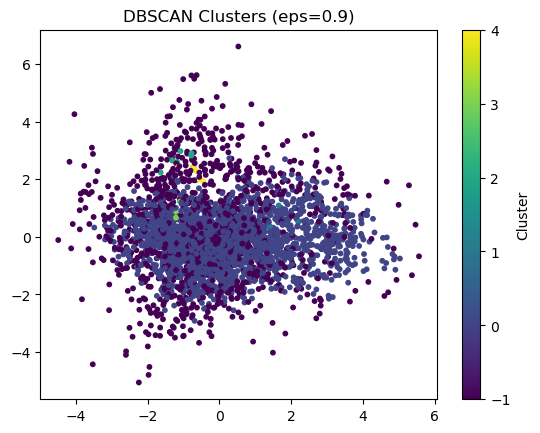

In [29]:
# once again, let's do a quick visualization of what our clusters look like in a lower-dimensional space
pca = PCA(n_components=2) # 2 dimensions
features_pca = pca.fit_transform(features_yeo_df)

# plot clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f"DBSCAN Clusters (eps={eps_val})")
plt.colorbar(label='Cluster')
plt.show()

# FULL DATASET - Results

In [33]:
# let's add the cluster labels to our original dataframe
votecensus_2020_clustered['kmeans_labels'] = kmeans_labels # add kmeans cluster
votecensus_2020_clustered['dbscan_labels'] = dbscan_labels # add dbscan cluster

From our DBScan efforts, we know that cluster labels -1 are noise points and cluster labels 0 are a massive cluster that is not of interest to us. So, in order to move forward with our analysis, we will take a slice of our dataset that does not include these observations.

In [35]:
votecensus_2020_clustered_slice = votecensus_2020_clustered[votecensus_2020_clustered.dbscan_labels > 0]
#votecensus_2020_clustered_slice.head(20).sort_values(['dbscan_labels', 'kmeans_labels'])
votecensus_2020_clustered_slice.shape
# tells us we have reducde our dataset to only 20 counties. cool!

(20, 14)

In [37]:
# we save this slice of 20 observations and try to gather insights from it manually
votecensus_2020_clustered_slice.to_csv('../data/results/votecensus_2020_clustered_slice.csv', index=False)
# NOTE: the counties found in this slice inform our later explorations of the 'PNW Cluster' and the 'South Cluster'. 


# PART TWO - SUBSET of DATASET
Now we continue with the second dataset, which is a subset of the first. 
As a reminder, this subset is created by taking only counties that had above-average changes in margins from 2012-16 AND from 2016-20. The measure of these changes in margins is a simple ABS(margintT2 - marginT1), which we repeat for (T1 = 2012, T2 = 2016) and (T1 = 2016, T2 = 2020).

In [39]:
# begin by loading data
votecensus_2020_subset = pd.read_csv('../data/clean/votemargins_census_joined_2020_subset_largemargins.csv') # relative path
votecensus_2020_subset_clustered = votecensus_2020_subset.copy() # to keep our raw data safe

# drop id columns
no_id_cols = votecensus_2020_subset_clustered.drop(columns=['unique_id', 'year', 'state_po', 'county_name'])  # drop ID columns for preprocessing
# drop non-feature columns
features = no_id_cols.drop(columns=['totalvotes','margin_2012', 'margin_2016', 'margin_2020', 'abs_delta_2012_16', 'abs_delta_2016_20']) # drop non-clustering columns
features.columns

# we get rid of margins in other years as well as absolute measures of change

Index(['votemargin_DR', 'proportion_explained_by_DR', 'delta_2012_16',
       'delta_2016_20', 'Education', 'Immigration', 'Income', 'Unemployment',
       'Marital'],
      dtype='object')

# SUBSET - YEO-Johnson Transformation (Alternative to Standardization)

In [41]:
# unfortunately we have to standardize again because this is a new dataset with fewer observations and 2 new columns

from sklearn.preprocessing import PowerTransformer # repeat same standardization procedures as with full dataset
pt = PowerTransformer(method='yeo-johnson')
features_yeo = pt.fit_transform(features)
features_yeo_df = pd.DataFrame(features_yeo, columns=features.columns)

# SUBSET - KMEANS

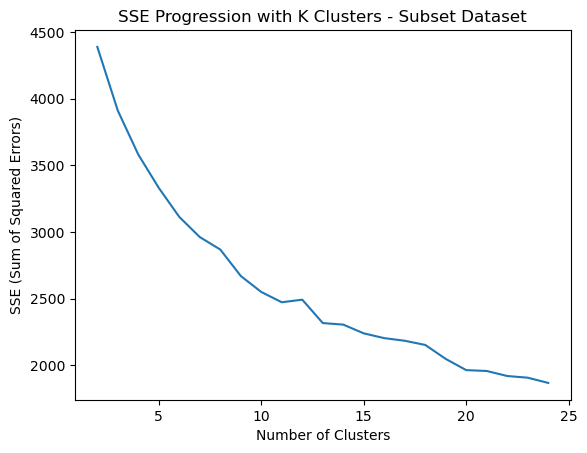

In [43]:
# same as with full dataset, we 
# run a loop to find best k over range 2-20

# inertia is sum of all SSE (Sum Square Errors) 
inertia = [KMeans(n_clusters=i).fit(features_yeo_df).inertia_ for i in range(2,25)]

# plot into elbow plot
plt.plot(range(2,25), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('SSE Progression with K Clusters - Subset Dataset')
plt.show()

In [45]:
# again, we look for more granularity
# iterate through different values of k
for k in range(2, 25):
    # fit the KMeans model
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(features_yeo_df)
    
    # compute silhouette score
    score = silhouette_score(features_yeo_df, labels)
    
    # count the number of observations in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # print results
    print(f"K = {k}")
    print(f"Silhouette Score: {score:.4f}")
    print("Cluster Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Cluster {label}: {count} observations")
    print("-" * 50)


K = 2
Silhouette Score: 0.2839
Cluster Distribution:
  Cluster 0: 211 observations
  Cluster 1: 469 observations
--------------------------------------------------
K = 3
Silhouette Score: 0.1635
Cluster Distribution:
  Cluster 0: 221 observations
  Cluster 1: 284 observations
  Cluster 2: 175 observations
--------------------------------------------------
K = 4
Silhouette Score: 0.1599
Cluster Distribution:
  Cluster 0: 176 observations
  Cluster 1: 252 observations
  Cluster 2: 121 observations
  Cluster 3: 131 observations
--------------------------------------------------
K = 5
Silhouette Score: 0.1497
Cluster Distribution:
  Cluster 0: 212 observations
  Cluster 1: 213 observations
  Cluster 2: 66 observations
  Cluster 3: 35 observations
  Cluster 4: 154 observations
--------------------------------------------------
K = 6
Silhouette Score: 0.1499
Cluster Distribution:
  Cluster 0: 169 observations
  Cluster 1: 187 observations
  Cluster 2: 67 observations
  Cluster 3: 25 observat

In [47]:
# seems like 10 is a good place to stop, even though silhouette drops pretty badly from k = 3, 4

# so lets fit our actual model
k = 10
model = KMeans(n_clusters=k, random_state=42)
kmeans_labels = model.fit_predict(features_yeo_df)

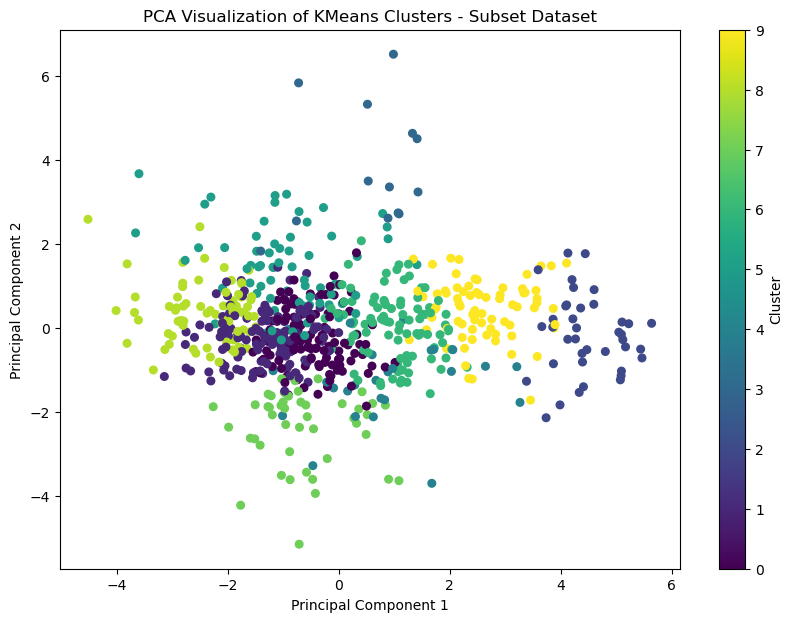

In [49]:
# and visualize again the clusters in a dimensionality-reduced 2d plot

# apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_yeo_df)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 7))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of KMeans Clusters - Subset Dataset')
plt.show()

# SUBSET - DBSCAN

In [51]:
# again, we look at different epsilon values
for eps_val in [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:  # test multiple values
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features_yeo_df)
    print(f"eps={eps_val}, Number of Clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}, Noise Points: {np.sum(dbscan_labels == -1)}")

eps=0.5, Number of Clusters: 0, Noise Points: 680
eps=0.6, Number of Clusters: 0, Noise Points: 680
eps=0.7, Number of Clusters: 0, Noise Points: 680
eps=0.8, Number of Clusters: 0, Noise Points: 680
eps=0.9, Number of Clusters: 4, Noise Points: 645
eps=1, Number of Clusters: 10, Noise Points: 554
eps=1.1, Number of Clusters: 10, Noise Points: 433
eps=1.2, Number of Clusters: 5, Noise Points: 332
eps=1.3, Number of Clusters: 2, Noise Points: 269
eps=1.4, Number of Clusters: 2, Noise Points: 210
eps=1.5, Number of Clusters: 1, Noise Points: 168
eps=1.6, Number of Clusters: 1, Noise Points: 142
eps=1.7, Number of Clusters: 2, Noise Points: 106
eps=1.8, Number of Clusters: 4, Noise Points: 69
eps=1.9, Number of Clusters: 2, Noise Points: 57
eps=2, Number of Clusters: 1, Noise Points: 51


In [53]:
# again wanting to strike a balance between # clusters and proportion noise points,
# seems like 1.8 is a good eps to set
# noise points is only ~10% and we get 4 clusters-- great!

# let's create the actual model
eps_val = 1.8
dbscan = DBSCAN(eps=eps_val, min_samples=5) 
dbscan_labels = dbscan.fit_predict(features_yeo_df)

# check the cluster labels to see that things are working as expected
print("Cluster Labels:", set(dbscan_labels))
noise_percentage = np.sum(dbscan_labels == -1) / len(dbscan_labels) * 100
print(f"Noise Percentage: {noise_percentage:.2f}%") # proportion of noise


# looks like 9.26% noise for 680 obvs total, which means
#680*0.0926

Cluster Labels: {0, 1, 2, 3, -1}
Noise Percentage: 10.15%


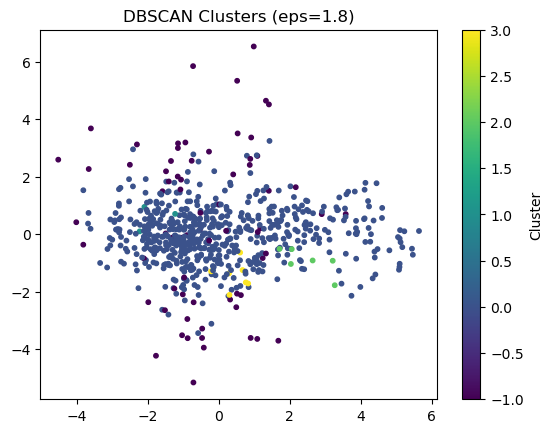

In [55]:
# visualize one last clustering using PCA in 2d
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_yeo_df)

# plot clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f"DBSCAN Clusters (eps={eps_val})")
plt.colorbar(label='Cluster')
plt.show()

# SUBSET - RESULTS

In [57]:
# as before, we add the cluster labels to our original dataframe
votecensus_2020_subset_clustered['kmeans_labels'] = kmeans_labels # add kmeans cluster
votecensus_2020_subset_clustered['dbscan_labels'] = dbscan_labels # add dbscan cluster

In [59]:
# and drop the not-helpful dbscan labels of: noisepoint, cluster0
votecensus_2020_subset_clustered_slice = votecensus_2020_subset_clustered[votecensus_2020_subset_clustered.dbscan_labels > 0]

votecensus_2020_subset_clustered_slice.sort_values(['dbscan_labels', 'kmeans_labels'])
votecensus_2020_subset_clustered_slice.shape
# tells us we have reducde our dataset to only 16 counties. now we can explore them.


(16, 21)

In [61]:
votecensus_2020_subset_clustered_slice.to_csv('../data/results/votecensus_2020_clustered_slice_largemargins.csv', index=False)
# NOTE: the counties found in this slice inform our later explorations of the 'Utah Cluster''. 